## Using Modis Satellite data from NASA to Create Generative Model of Future Canadian Forest Fires by using VAE

Data source and credit: NASA MODIS satellite (link: https://firms.modaps.eosdis.nasa.gov/download/)

VAE heavily insired by: Alexander Van de Kleut (link: https://avandekleut.github.io/vae/) (A fantastic read)

In [111]:
import torch, os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Import Data

In [112]:
dataset = []
for csv in os.listdir('data'):
    year = int(csv[6:10])
    df = pd.read_csv('data/' + csv)
    df.insert(0, 'year', year)
    
    dataset.append(df)

dataset = pd.concat(dataset)

dataset['daynight'] = (dataset['daynight'] == 'D').astype(int)*2-1


#### Fire Detection Frequency by Year

slope: 873.833766233766 +/- 855.1779114006943, intercept: -1708375.3471861468
p value that slope is non-zero:  0.3197034564838454


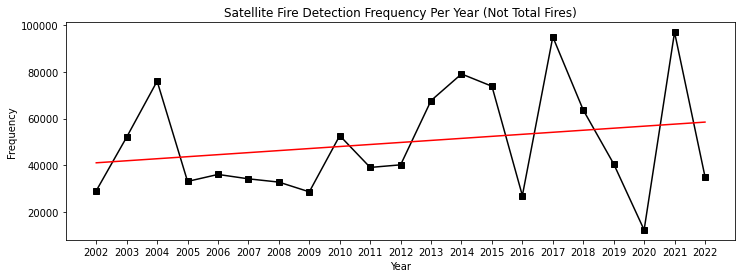

In [113]:
from scipy.stats import linregress

freq = dataset.set_index('year')['confidence'] <= 100
freq = freq.groupby('year').agg('count')


X = freq.index.to_numpy()
y = freq.to_numpy()
slope, intercept, r, p, se = linregress(X, y)

print(f'slope: {slope} +/- {se}, intercept: {intercept}')
print('p value that slope is non-zero: ', p)


plt.figure(figsize = [12,4])
plt.title('Satellite Fire Detection Frequency Per Year (Not Total Fires)')
plt.xlabel('Year')
plt.ylabel('Frequency')
X_plot = np.array([2002, 2022])
plt.plot(freq, marker = 's', color = 'black')
plt.plot(X_plot, X_plot*slope + intercept, label = 'linear regression', color='r')
plt.xticks(ticks = freq.index)
plt.show()


We find that the p-value is insignificant, and thus cannot say with confidence that fires are increasing linearly according to our data. This could be for a myriad of reasons. A few explanations: the fire detection instrument is prone to false-positive (this is discussed in the user manual, where sometimes forest clearings ellicit false positives), the fire detection instrument is double counting fires, etc. Other studies have found with statistical significance that forest fires in Canada ARE increasing and this should be noted.

#### Spatial Frequency of Fires

/tmp/ipykernel_199/1199220889.py:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


<Figure size 720x720 with 0 Axes>

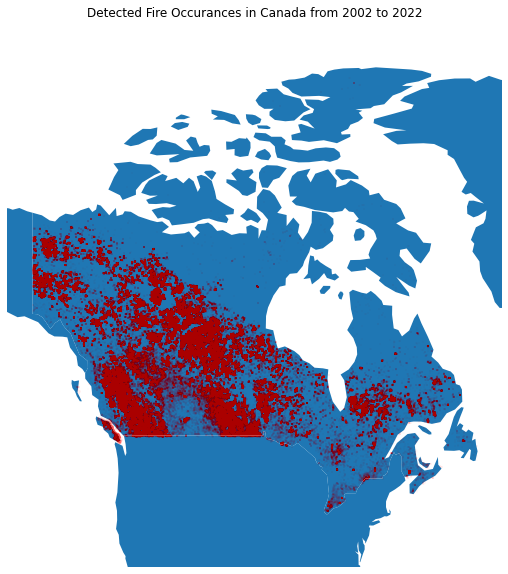

In [114]:
import geopandas

plt.figure(figsize = [10,10])
gdf = geopandas.GeoDataFrame(
    dataset[['longitude', 'latitude']], geometry=geopandas.points_from_xy(dataset.longitude, dataset.latitude), crs="EPSG:4326"
)
#filepath ='shape/lpr_000b16a_e.shp'
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = gdf.plot(ax=world.plot(figsize=(10, 10)), marker='s', color='red', markersize=1, alpha = 0.01)
ax.set_title('Detected Fire Occurances in Canada from 2002 to 2022')
minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx - 5, maxx + 5)
ax.set_ylim(miny - 5, maxy + 5)
ax.set_axis_off()
plt.show()

We can see by heatmap below, that the highest concentration of fires occurs in BC, from the Okanagan Northward.

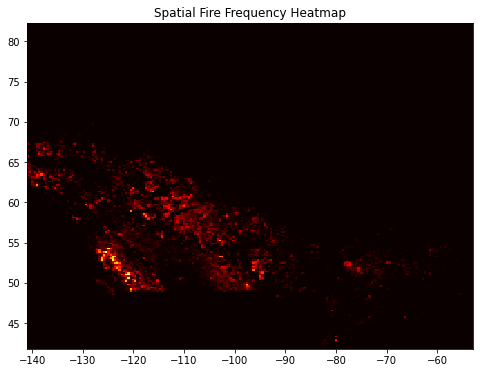

In [115]:
plt.figure(figsize = [8,6])
plt.title('Spatial Fire Frequency Heatmap')
plt.hist2d(dataset['longitude'], dataset['latitude'], bins = 200, cmap='hot')
#plt.xlim(-130, -90)
#plt.ylim(55, 70)
plt.show()

#### Covariance Matrix of Parameters

frp is predicted power output in MW, brightness is temperature in K

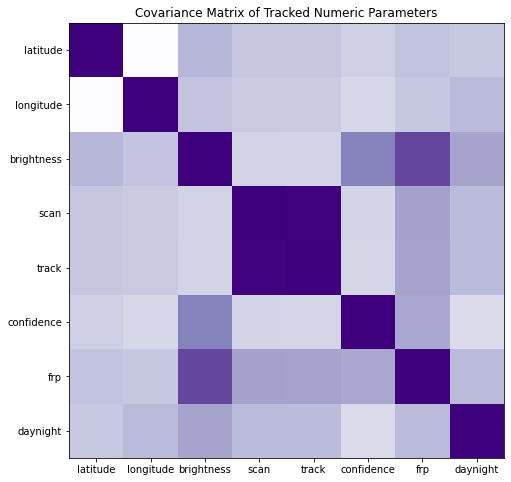

In [116]:
numerics = dataset[['latitude','longitude','brightness','scan','track','confidence','frp','daynight']]
center = numerics.mean()
std = numerics.std()
numerics = (numerics - center)/std
cov_mat = numerics.cov()

plt.figure(figsize = (8,8))
plt.title('Covariance Matrix of Tracked Numeric Parameters')
plt.imshow(cov_mat, cmap='Purples')
plt.xticks(ticks = np.arange(0, cov_mat.shape[0]), labels=['latitude','longitude','brightness','scan','track', 'confidence','frp','daynight'])
plt.yticks(ticks = np.arange(0, cov_mat.shape[0]), labels=['latitude','longitude','brightness','scan','track', 'confidence','frp','daynight'])
plt.show()

We find interestingly that confidence is correlated with brightess, and brightness is correlated with power output. Of course, longitude and latitude are uncorrelated. This all makes logical sense. Another interesting thing to note is that day and night time do not affect confidence as much, which is unexpected. The lack in correlation between variables suggests that dimensionality reduction may be unnecessary for inferences.

#### Gaussian Feature Map for Decreased Resolution

We will place Gaussian radial basis functions on a NxN grid over Canada. The Gaussians will measure the distance to the fires, and we can add these basis functions in the case of multiple fires. This is ideal for our purposes. The Gaussians will lower the resolution of canada to have less input parameters (the satellite considers every pixel of 1km^2, whichis far too large).
$$
\phi_{\vec{z}} (\vec{x})= \exp{(\frac{(\vec{x} - \vec{z})^2}{2\Delta})}
$$
Where $\vec{z}$ is the position of the radial basis function on the grid and $\vec{x}$ is the latitude and longitude position of the fire. 

max and min of featuremap (+1, -1 is ideal): 0.880138635635376 -0.6481870412826538


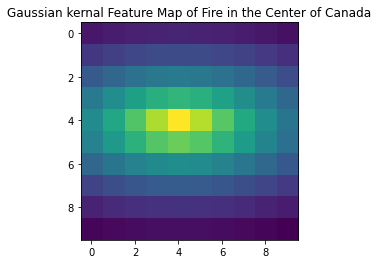

In [117]:
N = 10
gaussian_pos_x = torch.linspace(dataset['longitude'].min(), dataset['longitude'].max(), N)
gaussian_pos_y = torch.linspace(dataset['latitude'].min(), dataset['latitude'].max(), N)

x_grid, y_grid = torch.meshgrid((gaussian_pos_x, gaussian_pos_y))
grid = torch.stack((x_grid, y_grid)).permute(1, 2, 0)



def gaussian_grid(points, grid_, delta = 30):
    # points is of shape (batch, 2) where batch is number of points and 2 is spatial (long and lat)
    # we return a B x N^2 tensor which represents the fire distribution in Gaussian basis function space

    if len(points.shape) != 2:
        points = points.view(1, points.size)
    
    # batch size
    B = points.shape[0]

    grid_ = grid_.view(int(N**2), 2).unsqueeze(0).repeat(B, 1, 1)

    points = points.view(B, 1, 2)
    
    # compute N^2 vector
    return torch.exp(-torch.cdist(grid_, points, p=2)*2/(2*delta)).squeeze()*2 - 1


points = torch.tensor([[-100., 60.]])

featuremap = gaussian_grid(points, grid)
plt.title('Gaussian kernal Feature Map of Fire in the Center of Canada')
plt.imshow(featuremap.view(N, N))
print('max and min of featuremap (+1, -1 is ideal):', featuremap.max().item(), featuremap.min().item())


#### Constructing Dataset for VAE

Our goal is to sample novel Canadian fire conditions, given previous fire history. We will use a variational autoencoder, although I have also considered deep restricted Boltsmann machines and MCMC. We will then explore latent space nearby historic data to see what could happen in the future. This could be used to plan for worst case scenarios, etc.

We will measure over windows of a few months for datapoints, and the locations of all of the fires will be the state (we add a few more parameters as well).

Features of the dataset include: the sum of all feature maps of fire locations within the timeframe (we will have to normalize and center afterwards for NN effectiveness), cumulative frp over the month (pixel-integrated power output in MW), the month of the year itself (we will transform this from -1 to 1 for january to dec)

In [118]:
dataset['acq_date'] = dataset['acq_date'].astype('datetime64[ns]')
dataset = dataset.set_index('acq_date')

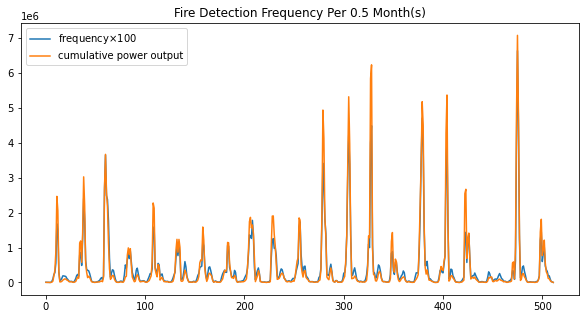

torch.Size([512, 102])


In [119]:
import datetime as dt

# numebr of features for input dim
N_features = int(N**2 + 2)

# the window over which we see the fires
month_delta = 1
# the stride of our data (if it is less than 1, it means we have highly correlated data, since fires can contribute to more than one datapoint)
stride = 0.5

dataset = dataset.sort_index()

X_tr = []
freq = []
powers = []


date = dt.datetime(2002, 1, 1)
time_d = dt.timedelta(days = 30)


while date < dataset.index.max():

    window = dataset[date:date + time_d]
    freq.append(window.index.size)

    if window.empty:
        X_tr.append([*[-1. for _ in range(int(N**2))], 0.,  ((date.month-1)*2 / 11 - 1) + ((date.day) - 1)/(30*12)])
        continue


    lats = window.latitude.to_numpy()
    lons = window.longitude.to_numpy()

    # fire power output and time of year
    cum_frps = window.frp.sum()                                  # total power of fires output this month 
    mon = ((date.month-1)*2 / 11 - 1) + ((date.day) - 1)/(30*12) # date value is from -1 to 1 from january to dec


    powers.append(cum_frps)

    # fire frequency heatmap/featuremap
    fmap = torch.zeros(int(N**2))

    for i in range(lons.size):

        pnt = torch.tensor([[lons[i], lats[i]]])

        phi = gaussian_grid(pnt.float(), grid)
        fmap += phi.squeeze()

    X_tr.append([*fmap.tolist(), cum_frps, mon])

    date += dt.timedelta(days = round(stride*30*month_delta))

X_tr = torch.tensor(X_tr)


# center and normalize data -- remember to convert back afterwards
X_center = torch.mean(X_tr, dim=0).float()
X_std =    torch.std(X_tr, dim=0).float()
X_tr = (X_tr - X_center.unsqueeze(0).repeat(X_tr.shape[0], 1))/X_std.unsqueeze(0).repeat(X_tr.shape[0], 1)


plt.figure(figsize = [10,5])
plt.title(r'Fire Detection Frequency Per %.1f Month(s)' % float(month_delta * stride))
plt.plot(np.array(freq)*1e2, label = r'frequency$\times100$')
plt.plot(powers, label = 'cumulative power output')
plt.legend()
plt.show()
print(X_tr.shape)


We see unsuprisingly that power output and frequency are proportional, and that power/frequency spike every summer when the wildfires get out of control. We also see the clear increase in fire power output in summers of recent years.

#### Train-test split (we can add validation if we would like)

In [120]:
# shuffle
idx = torch.randperm(X_tr.shape[0])
X_tr = X_tr[idx]

# split
split_ind = int(0.8*(X_tr.shape[0]))
X_te = X_tr[split_ind:]
X_tr = X_tr[:split_ind]

# float
X_tr = X_tr.float()
X_te = X_te.float()


In [121]:
from torch import nn, optim
from torch.nn import functional as F

def get_mse(X_t, mod):
    pred = mod(X_t).detach().numpy()
    mse = np.sum((X_t.numpy() - pred)**2)/(X_t.shape[0])
    return mse


#### Training VAE

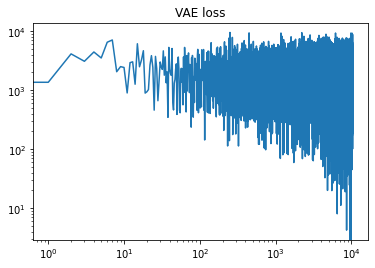

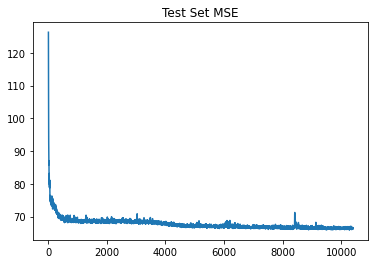

In [122]:
from VAE import VariationalAutoencoder

latent_space = 64
epochs = 800
batch_size = 32
hidden_width = 300


model = VariationalAutoencoder(N_features, latent_space, hidden_width_1=hidden_width, hidden_width_2=hidden_width)
    
optimizer = optim.Adam(model.parameters(), lr=1e-4)

dataloader = torch.utils.data.DataLoader(X_tr, batch_size=batch_size, shuffle=True)


# inspired by https://avandekleut.github.io/vae/

losses = []
mses = []
opt = torch.optim.Adam(model.parameters())
for i in range(epochs):
    for X_i in dataloader:

        opt.zero_grad()
        X_hat = model(X_i)
        loss = ((X_i - X_hat)**2).sum() + model.encoder.kl
        loss.backward()
        opt.step()
        losses.append(loss.detach().item())
        mses.append(get_mse(X_te, model))


losses = np.array(losses)
losses -= losses.min() + 1
plt.figure()
plt.title('VAE loss')
plt.loglog(losses)
plt.show()

plt.figure()
plt.title('Test Set MSE')
plt.plot(mses)
plt.show()



Training, as we can see is a bit of a noisy training procedure. However, we can see by the test error that the network is learning the low-dim representation of data. As we saw in the correlation matrix, there is little correlation between variables, so we need a large latent dimension. We have also neglected validation for optimal hyperparameters. This is due to our small amount of data, and our current parameters will suffice for the time being.

In [123]:
torch.save(model, 'trainedvae.t')

#### Using Trained VAE to Generate Synthetic Fire Data

We go through each month, select a real instance of recorded data, and then we jump to a neaby point in latent space. This is then decoded for a (hopefully) decently realistic generative instance of fire data.

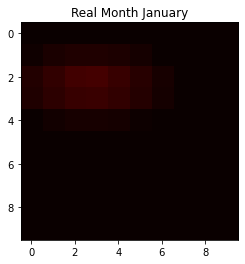

power out: 25478.00 MW
generative output month 10.137508004903793
generative_output power 1063923.75MW


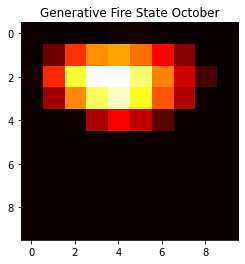

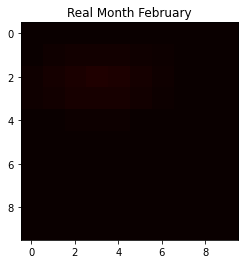

power out: 10159.50 MW
generative output month 3.2942749559879303
generative_output power 242427.94MW


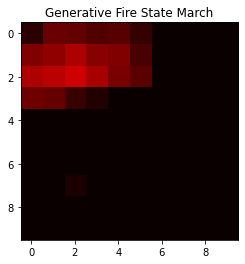

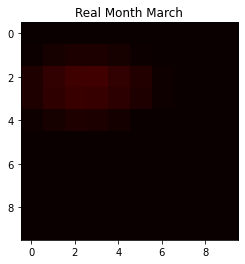

power out: 15346.69 MW
generative output month 10.19003877043724
generative_output power 713328.50MW


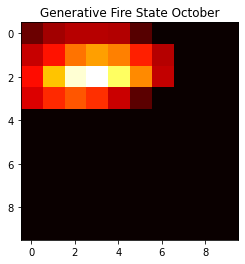

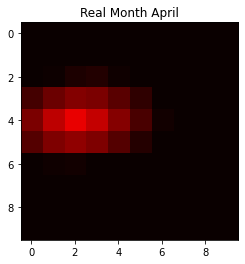

power out: 95992.69 MW
generative output month 8.326467081904411
generative_output power 813686.12MW


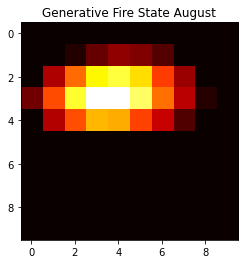

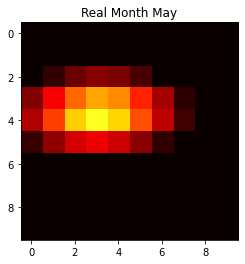

power out: 562336.00 MW
generative output month 5.312963366508484
generative_output power 1394576.00MW


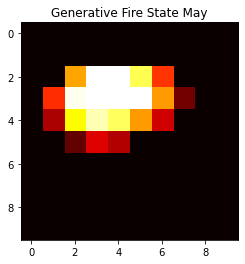

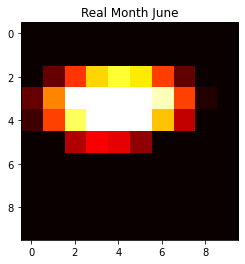

power out: 1369892.25 MW
generative output month 4.681126996874809
generative_output power 1393267.50MW


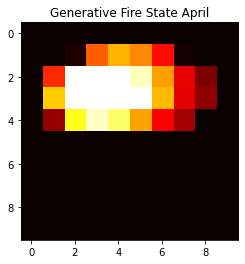

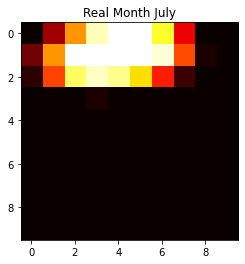

power out: 1146330.50 MW
generative output month 4.839259386062622
generative_output power 1381636.25MW


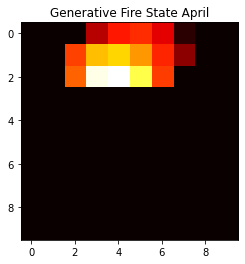

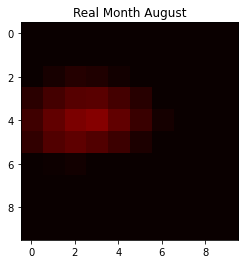

power out: 57450.91 MW
generative output month 7.213480748236179
generative_output power 575571.88MW


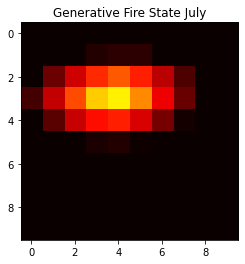

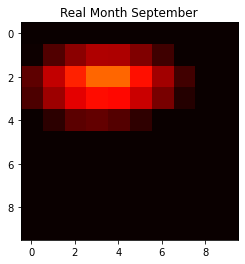

power out: 243540.61 MW
generative output month 3.310167610645294
generative_output power 363147.00MW


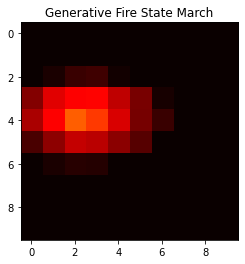

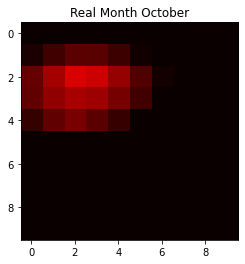

power out: 112323.22 MW
generative output month 3.4238686561584473
generative_output power 122154.50MW


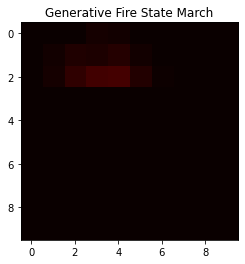

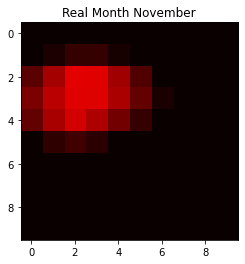

power out: 163072.59 MW
generative output month 9.977769762277603
generative_output power 892239.00MW


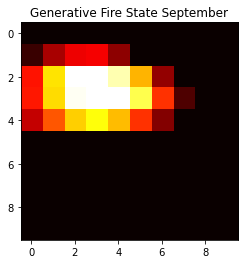

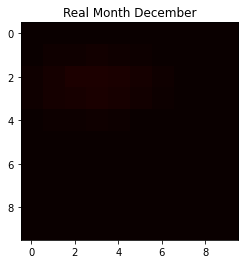

power out: 9546.91 MW
generative output month 3.4960047006607056
generative_output power 29578.66MW


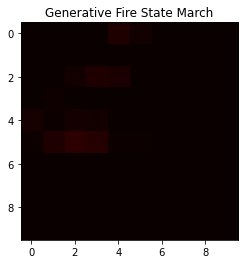

In [124]:
# goal -- find datapoint for each month of the year then take a random sample nearby in latent space

# how close the generated point is to the real point in latent space
variation = 1

month_values = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}

model = torch.load('trainedvae.t')

months_X_te = (X_te[:,-1]*X_std[-1] + X_center[-1] + 1)/2 * 11  + 1


for i in range(12):

    # as an example, the first datapoint in X_te which refers to our desired month
    ind_i = torch.where(torch.logical_and(months_X_te >= i+1,  months_X_te <= i+2))[0][0].item()

    X_month = X_te[ind_i] * X_std + X_center

    # display real month fire dist
    plt.figure()
    plt.title(r'Real Month %s' % (month_values[i+1]))
    plt.imshow(X_month[:int(N**2)].view(N,N), cmap = 'hot')
    plt.clim(0,3500)
    plt.show()
    print('power out: %.2f MW' % X_month[-2].item())

    # generate point in latent space nearby and then decode to generate new state
    noise = torch.randn(1, latent_space) * variation
    Z_month = model.encoder(((X_month - X_center)/X_std).float().view(1,-1)).detach()
    generative_state = Z_month + noise
    generative_output = model.decoder(generative_state).detach().squeeze()

    # convert to readable units
    generative_output = generative_output * X_std + X_center
    mon = (generative_output[-1].item() + 1)/2 * 11  +1

    print('generative output month', mon)
    print('generative_output power %.2fMW' % (F.relu(generative_output[-2])))

    
    # generated data fire dist
    mapping = generative_output[:int(N**2)].view(N,N)
    plt.figure()
    plt.title(r'Generative Fire State %s' % (month_values[int(np.floor(mon))]))
    plt.imshow(mapping, cmap = 'hot')
    plt.clim(0, 3500)
    plt.show()



We see that the generated data from our VAE is somewhat flawed but still decent. For one, it can attain negative power outputs, which is aphysical (hence we take ReLU of the power). We can also see that sometimes the fire locational data will become erratic. However, a majority of the time, it seems reasonable, and thus perhaps can be used to simulate future years. This of course neglects the fact that fires will be getting worse due to climate change, as it has only seen historic data.